In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import scipy.sparse

matplotlib.style.use('ggplot')

In [2]:
# Loading Data
df  = pd.read_csv("train.csv")
#(40428967, 24)
dft  = pd.read_csv("test.csv")
#(4577464, 23)

STEP ONE: DATA EXPLORATION

In [3]:
def basicDes(df):
    for col in df.columns:
        print('Unique values for {}:\n{}\nwith {} values\n'.format(col,df[col].unique(),len(df[col].unique())))

In [8]:
# describe the training dataset
basicDes(df)

Unique values for id:
[  1.00000942e+18   1.00001693e+19   1.00003719e+19 ...,   9.99958512e+18
   9.99963634e+18   9.99974664e+18]
with 40428967 values

Unique values for click:
[0 1]
with 2 values

Unique values for hour:
[14102100 14102101 14102102 14102103 14102104 14102105 14102106 14102107
 14102108 14102109 14102110 14102111 14102112 14102113 14102114 14102115
 14102116 14102117 14102118 14102119 14102120 14102121 14102122 14102123
 14102200 14102201 14102202 14102203 14102204 14102205 14102206 14102207
 14102208 14102209 14102210 14102211 14102212 14102213 14102214 14102215
 14102216 14102217 14102218 14102219 14102220 14102221 14102222 14102223
 14102300 14102301 14102302 14102303 14102304 14102305 14102306 14102307
 14102308 14102309 14102310 14102311 14102312 14102313 14102314 14102315
 14102316 14102317 14102318 14102319 14102320 14102321 14102322 14102323
 14102400 14102401 14102402 14102403 14102404 14102405 14102406 14102407
 14102408 14102409 14102410 14102411 14102412 

Note that all of the features of categorical, and the number of categories of different features vary a lot 
from 2 to as large as 6729486, indicating that we might need some feature engineering to re-categorize some of the features.
Also, one-hot encoding might be a proper representation we want to use since features are categorical.

In [9]:
basicDes(dft)

Unique values for id:
[  1.00001741e+19   1.00001825e+19   1.00005541e+19 ...,   9.99880237e+16
   9.99908657e+18   9.99926365e+16]
with 4577464 values

Unique values for hour:
[14103100 14103101 14103102 14103103 14103104 14103105 14103106 14103107
 14103108 14103109 14103110 14103111 14103112 14103113 14103114 14103115
 14103116 14103117 14103118 14103119 14103120 14103121 14103122 14103123]
with 24 values

Unique values for C1:
[1005 1010 1012 1002 1007 1001 1008]
with 7 values

Unique values for banner_pos:
[0 1 7 2 4 3]
with 6 values

Unique values for site_id:
['235ba823' '1fbe01fe' '85f751fd' ..., '4327e528' '3525557b' 'feb793b0']
with 2825 values

Unique values for site_domain:
['f6ebf28e' 'f3845767' 'c4e18dd6' ..., 'bd3148f5' '94c52720' '7e4dbca9']
with 3366 values

Unique values for site_category:
['f028772b' '28905ebd' '50e219e0' '3e814130' 'c0dd3be3' '75fa27f6'
 'dedf689d' '335d28a8' 'f66779e6' '8fd0aea4' '72722551' '0569f928'
 '70fb0e29' '76b2941d' '42a36e14' '9ccfa2ea' 'a

Notice that the number of unique values for the same features in the test set are different from those in the training set
(e.g.Unique values for app_domain for training set is 559, for test set is 201),
a closer look at these features indicates that the values of features in test set are subsets of those in the training data.
This also indicates that we should use the whole training set to do the encoding the data because any sample of training set 
might not cover all the possible values in the test set, and led to problems in prediction.        

In [10]:
# explore key variable

In [11]:
# Click through rate(CTR)
print (df['click'].describe())

count    4.042897e+07
mean     1.698056e-01
std      3.754620e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: click, dtype: float64


Mean of click through rate is 0.1698, see this as baseline. Also this also indicates that the training set is quite 
imbalanced, need to balance the class weights in training.

In [14]:
# time trend
df['hour'].value_counts(normalize=False, sort=True, ascending=False)

14102209    447783
14102210    438270
14102813    432308
14102212    408650
14102814    387453
14102211    386757
14103004    347806
14102809    328576
14102213    323480
14102208    322803
14102808    291763
14102206    288819
14102205    286697
14102816    283491
14102815    282315
14102817    280835
14102105    273500
14102304    273173
14102812    272124
14102104    264711
14102417    262579
14103014    259187
14102810    258656
14102811    257891
14102416    252154
14103013    250441
14103012    249022
14102315    246297
14103005    244765
14102514    242500
             ...  
14102121     89501
14102300     89341
14102622     88869
14102122     88436
14103000     87333
14102723     87207
14102702     85828
14103023     83608
14102800     82520
14102400     82137
14102621     82130
14102601     80863
14102501     80637
14102200     78006
14102504     76816
14102623     76770
14102523     76506
14102701     75382
14102123     73940
14102500     73446
14102600     72185
14102503    

In [25]:
# time trend exploration
timeDF = df[['click','hour']]
tt = timeDF.groupby('hour').mean()

In [26]:
def time_graph(x,y):
    x = np.array(list(range(len(x))))
    y = np.array(y)
    plt.plot(x,y,'r')
    plt.title('Time Trend of Click Through Rate(CTR)')
    plt.xlabel('Time')
    plt.ylabel('CTR')
    plt.xlim([-0.05, np.max(x)])
    plt.ylim([np.min(y)-0.1, np.max(y)+0.1])

In [20]:
%matplotlib inline

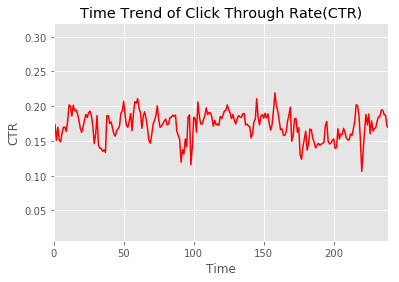

In [28]:
# visualize the time trend
time_graph(df['hour'].unique(),tt)

The figure indicates that CTR is mostly in the range of (0.15,0.2) in all hours of all dates, does not vary too much on
different dates. We might now want to split out the effect of dates and hours. 
Let us create variables to see if hours in the range of (0,23) and dates(141021-141030)is correlated with CTR.

In [4]:
# create hour and date features
hourd = []
dated = []
for val in df['hour'].values:
    hourd.append(int(str(val)[-2:]))
    dated.append(int(str(val)[:-2]))
hourd = pd.Series(hourd)
dated = pd.Series(dated)

In [6]:
# add to dataframe and get mean of CTR
timeDF['hourd'] = hourd
timeDF['dated'] = dated

tth = timeDF.groupby('hourd').mean()['click']
ttd = timeDF.groupby('dated').mean()['click']

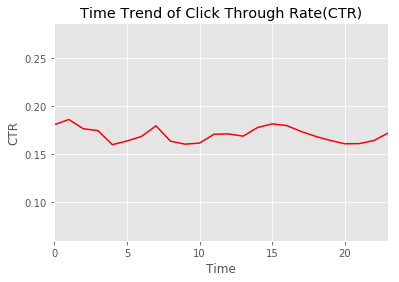

In [35]:
# visualize the hour time trend
time_graph(timeDF['hourd'].unique(),tth)

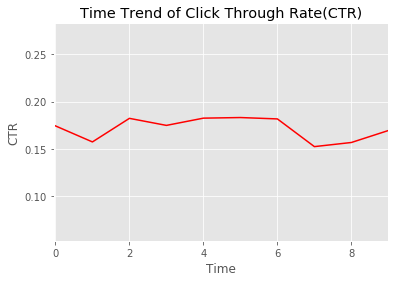

In [36]:
# visualize the date time trend
time_graph(timeDF['dated'].unique(),ttd)

From these two figures we also find that the CTR distributes relatively evenly according to hour and date, so we do not need 
to remove time trend. Also, we can sample according to time uniformly to get our training sample. In this case, I decide to 
use 1% of each hour (according to the 'hourd' variable) to get my sample for training later. 
We might also want to use the 'hourd' variable to replace the original 'hour' variable to represent the time feature in our training since 'hourd' has lower dimensionality without much loss in approximating the original 'hour' distribution.

STEP TWO: FEATURE ENGINEERING

In [7]:
# first we could want to add the 'hourd' variable into the training dataframe
df['hourd'] = hourd

In [8]:
#create the same 'hourd' feature for the test set
hourd_test = []
for val in dft['hour'].values:
    hourd_test.append(int(str(val)[-2:]))
hourd = pd.Series(hourd)
dft['hourd'] = hourd_test

In [11]:
len(list(dft))

24

In [12]:
len(list(df))

25

A further look at the unique values for features in the training set, we realize that 'device_id' has 2686408 unique values,
and 'device_ip' has 6729486 unique values. The high dimension and difficulty to re-categorize of these two variables make it 
reasonable to remove these two features for training.

In [13]:
# list features we are interested in
categorical_cols = ['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', \
                    'app_id', 'app_domain', 'app_category', 'device_model', 'device_type', \
                    'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hourd']

In [14]:
len(categorical_cols)

20

In [15]:
# combine the training and test set to preprocess the data as a whole
df_cate = pd.concat([df[categorical_cols], dft[categorical_cols]], ignore_index=False)

In [16]:
print (df.shape)

(40428967, 25)


In [17]:
print (dft.shape)

(4577464, 24)


In [18]:
print (df_cate.shape)

(45006431, 20)


now let's explore features with dimension of 1000 and above and see how we can re-categorize them

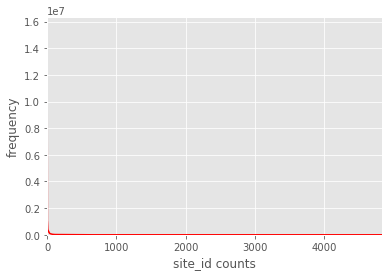

In [21]:
# now let's explore variables dimension of 1000 and above and see how we can re-categorize them
def general_graph(x,y,VarName):
    x = np.array(list(range(len(x))))
    y = np.array(y)
    plt.plot(x,y,'r')
    plt.xlabel(VarName)
    plt.ylabel('frequency')
    plt.xlim([-0.05, np.max(x)])
    plt.ylim([-0.05, np.max(y)+2])
general_graph(df_cate['site_id'].unique(),df_cate['site_id'].value_counts(),'site_id counts')

In [53]:
# the figure shows site_id has long tail distribution, the frequency reduced significantly from around 
#count top 100 site_ids. Hence I decide to re-categorize the site_id into 101 categories, with top 100
# site_id as they are, and the rest encode to one category as 'rest'
def create_new_var(name,dimension):
    target_set = set(df_cate[name].value_counts()[0:dimension].index.tolist())
#     print (target_set)
    new_val = []
    for val in df_cate[name].values:
        if val in target_set:
            new_val.append(val)
        else:
            new_val.append('rest')
    new_val = pd.Series(new_val)
    return new_val
# df_cate['site_id_enc'] = create_new_var('site_id',dimension)
site_id_enc = create_new_var('site_id',100)
df_cate['site_id_enc'] = site_id_enc

In [55]:
#now we check if the new variable has been added
print (list(df_cate))
print (len(df_cate['site_id_enc'].unique()))
print (df_cate['site_id_enc'].unique())

['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hourd', 'site_id_enc', 'site_domain_enc', 'app_id_enc', 'device_model_enc', 'C14_enc']
100
['1fbe01fe' 'rest' 'd6137915' 'e151e245' '84c7ba46' '9e8cf15d' '85f751fd'
 'd9750ee7' '0c2fe9d6' '543a539e' '6ec06dbd' '0eb72673' '5ee41ff2'
 '6256f5b4' 'e023ba3e' '5b08c53b' '856e6d3f' '83a0ad1a' 'f9c69707'
 'b7e9786d' '75f43c5a' '43d6df75' 'bb4524e7' '5b4d2eda' '93de26ae'
 'faf9c1c2' 'd8bb8687' '6c5b482c' '763a42b5' '26fa1946' '38217daf'
 '7697ed3e' '6399eda6' '89a490f5' '1b171d6d' '7dd19f44' '29229f8e'
 '0a742914' 'd7f3460b' '5114c672' '93eaba74' '9a977531' '7c6576be'
 'e3c09f3a' '17caea14' '61a8c644' 'e8f79e60' '9e8e8d09' 'c63170c5'
 '2328ee8e' '4bf5bbe2' '12fb4121' 'e5c60a05' '801dfefb' '7294ea0f'
 'c1fcc9a1' 'fec6e632' 'cbb01868' 'f61eaaae' '517b8671' '222acd54'
 '9ee9dd00' 'e4d8dd7

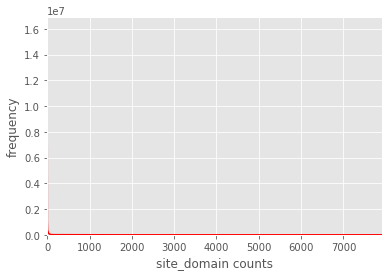

In [38]:
# do the same visualization for 'site_domain' feature with 7745 categories
general_graph(df_cate['site_domain'].unique(),df_cate['site_domain'].value_counts(),'site_domain counts')

In [56]:
# similarly, the figure shows 'site_domain' has long tail distribution, the frequency reduced significantly from around 
#count top 100 site_ids, hence we follow same approach
site_domain_enc = create_new_var('site_id',100)
df_cate['site_domain_enc'] = site_domain_enc

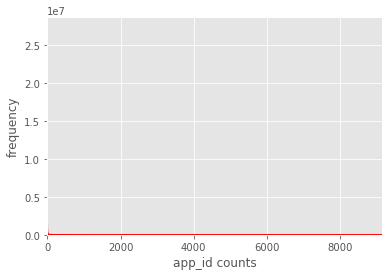

In [40]:
# do the same for 'app_id' with 8552 categories
general_graph(df_cate['app_id'].unique(),df_cate['app_id'].value_counts(),'app_id counts')

In [57]:
app_id_enc = create_new_var('app_id',100)
df_cate['app_id_enc'] = app_id_enc

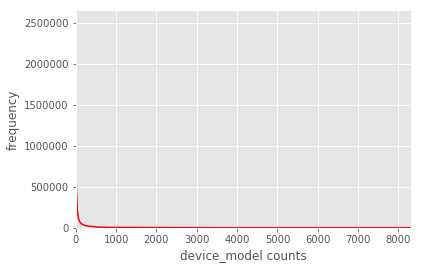

In [42]:
# for 'device_model' with 8251 values
general_graph(df_cate['device_model'].unique(),df_cate['device_model'].value_counts(),'device_model counts')

In [58]:
# note that the frequency reached to tail at between top 200-300, we choose dimension to be 250 
device_model_enc = create_new_var('device_model',250)
df_cate['device_model_enc'] = device_model_enc

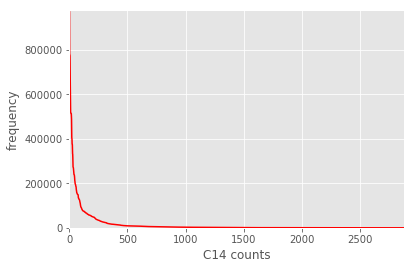

In [44]:
# finally, we do the same for 'C14' variable, with 2626 categories
general_graph(df_cate['C14'].unique(),df_cate['C14'].value_counts(),'C14 counts')

In [59]:
# according to the distribution, 500 is likely to be a reasonable choice
C14_enc = create_new_var('C14',500)
df_cate['C14_enc'] = C14_enc

In [60]:
# now let's check the name and shape of our dataframe 
print (list(df_cate))
print (df_cate.shape)

['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hourd', 'site_id_enc', 'site_domain_enc', 'app_id_enc', 'device_model_enc', 'C14_enc']
(45006431, 25)


In [61]:
# the new list of features we are interested in becomes the following
new_names = ['C1', 'banner_pos', 'site_category','app_domain', 
             'app_category','device_type', 'device_conn_type','C15', 
             'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hourd', 'site_id_enc', 
             'site_domain_enc', 'app_id_enc', 'device_model_enc', 'C14_enc']
print (len(new_names))

20


In [62]:
# now let's transform all of features into categorical integers
for col in new_names:
    df_cate[col] = pd.factorize(df_cate[col])[0]

In [52]:
basicDes(df_cate[new_names])

Unique values for C1:
[0 1 2 3 4 5 6]
with 7 values

Unique values for banner_pos:
[0 1 2 3 4 5 6]
with 7 values

Unique values for site_category:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
with 26 values

Unique values for app_domain:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 

Note that we find the unique values of df_cate(cancatenation of training and test set)
is different from the unique values of df(just the training set), see the following 
features as examples(name, df_cate unique values-df unique values]: 'C17',474-435;'app_domain',580-559; 'C17',474-435; 'C19', 69-68; 'C21',62-60
so it's necessary that we do the encoding in one step to avoid cases of unrecognized feature value
in prediction

In [63]:
print (len(df_cate['C14'].unique()))
print (df_cate['C14'].unique())

2885
[15706 15704 18993 ..., 24349 24328 24236]


In [64]:
print (len(df_cate['C14_enc'].unique()))
print (df_cate['C14_enc'].unique())

456
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 24

In [68]:
name = 'C14'
dimension = 500
target_set = set(df_cate[name].value_counts()[0:dimension].index.tolist())
print (target_set)
print (len(target_set))
new_val = []
for val in df_cate[name].values:
    if val in target_set:
        new_val.append(val)
    else:
        new_val.append('rest')
new_val = pd.Series(new_val)
print len((new_val))


{22541, 22552, 22553, 22554, 20508, 22561, 18489, 22587, 22598, 22599, 22607, 20560, 22614, 22624, 22633, 20596, 8330, 18574, 22672, 22676, 22677, 22680, 20633, 20634, 22683, 22681, 20632, 22682, 22684, 22685, 22686, 20635, 18595, 18588, 22700, 22701, 22702, 22703, 22713, 22738, 18648, 6360, 6362, 6361, 6364, 6365, 6366, 16615, 6392, 6393, 20751, 22809, 22810, 22811, 22812, 22813, 22814, 22815, 16685, 16687, 16688, 22832, 375, 377, 380, 22914, 22915, 22916, 22919, 22920, 24096, 24097, 6557, 6558, 6559, 6560, 24099, 6563, 22948, 22949, 18854, 22950, 18856, 22952, 18858, 22954, 22953, 22955, 452, 454, 16838, 456, 16841, 22987, 22988, 22989, 463, 22993, 6616, 16858, 16859, 23012, 20966, 23015, 23016, 20969, 20970, 23018, 20980, 20984, 21674, 21675, 20993, 20995, 20996, 20997, 20998, 20999, 16920, 21681, 21682, 21683, 18987, 21685, 18993, 23091, 23100, 19015, 19016, 4687, 16989, 23137, 23138, 23139, 23141, 23143, 23144, 17014, 17016, 17017, 23160, 23161, 23166, 23168, 23170, 23174, 17037, 

In [70]:
print (len(new_val.unique()))


501


In [71]:
df_cate['C14_enc'] = new_val

In [72]:
basicDes(df_cate[new_names])

MemoryError: 